In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_all.xltx to data_all.xltx


In [2]:
import pandas as pd

# Read the dataset ' data_all.xltx ' into a DataFrame
df = pd.read_excel("data_all.xltx", dtype=str, sheet_name=0)
df.to_csv("data_all.csv", index=False, encoding='utf-8-sig')

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# [2/6] معالجة التواريخ
print("\n[2/6] معالجة التواريخ...")

# إحصاء التواريخ المفقودة قبل البدء
initial_null_dates = df['activity_date'].isnull().sum()
print(f"   - عدد التواريخ المفقودة: {initial_null_dates:,}")


[2/6] معالجة التواريخ...
   - عدد التواريخ المفقودة: 54,401


In [4]:
# 1. تحويل العمود إلى Datetime مع معالجة التنسيقات المختلفة (Mixed Formats)
# هذا يضمن تحويل التواريخ سواء كانت (يوم-شهر) أو (شهر-يوم) بشكل صحيح
df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce', format='mixed')

# 2. حذف الصفوف التي فشل تحويلها أو كانت فارغة (NaT/NaN)

df = df.dropna(subset=['activity_date']).copy()

# 3. ترتيب البيانات زمنياً لكل حساب (Chronological Sort)

df = df.sort_values(by=['account_id', 'activity_date']).reset_index(drop=True)

print(f"   ✓ تم حذف {initial_null_dates:,} سجل بدون تاريخ أو بتنسيق خاطئ")
print(f"   ✓ تم تحويل التواريخ وترتيب البيانات زمنياً بنجاح")

   ✓ تم حذف 54,401 سجل بدون تاريخ أو بتنسيق خاطئ
   ✓ تم تحويل التواريخ وترتيب البيانات زمنياً بنجاح


In [5]:
# 3. معالجة الدول
print("\n[3/6] معالجة أسماء الدول...")
# 1. قائمة التصحيحات لتوحيد الأسماء ومعالجة مشاكل الترميز (Encoding)
country_mapping = {
    'Rأ©union': 'Reunion',
    'Guyane Franأ§aise': 'French Guiana',
    'CH': 'Switzerland',
    'IT': 'Italy',
    'BE': 'Belgium',
    'NL': 'Netherlands',
    'AT': 'Austria',
    'LU': 'Luxembourg',
    'DK': 'Denmark',
    'IE': 'Ireland',
    '[NULL]': np.nan,
    'nan': np.nan,
    'None': np.nan
}

# 2. تطبيق الاستبدال مع التأكد من إزالة المسافات الزائدة
df['Country'] = df['Country'].str.strip().replace(country_mapping)

# 3. معالجة القيم الفارغة (حذف السجلات التي لا تحتوي على دولة)
initial_null_countries = df['Country'].isnull().sum()
df = df.dropna(subset=['Country']).copy()

# 4. توحيد حالة الأحرف (Title Case) لضمان عدم تكرار "Italy" و "ITALY"
df['Country'] = df['Country'].str.title()

print(f"   ✓ تم توحيد أسماء الدول بنجاح")
print(f"   ✓ تم حذف {initial_null_countries:,} سجل بسبب عدم تحديد الدولة")


[3/6] معالجة أسماء الدول...
   ✓ تم توحيد أسماء الدول بنجاح
   ✓ تم حذف 301 سجل بسبب عدم تحديد الدولة


In [6]:
# [4/6] معالجة القيم المفقودة
print("\n[4/6] معالجة القيم المفقودة...")

# 1. معالجة حالة الفرصة (Opportunity Stage):

df['opportunity_stage'] = df['opportunity_stage'].fillna('no_opp').str.lower()

# 2. معالجة عمود Lead:

df['is_lead'] = df['is_lead'].fillna(1).astype(int)

# 3. معالجة أنواع الأنشطة (Activity Types):

initial_len = len(df)
df = df.dropna(subset=['types']).copy()

# 4. معالجة الحلول (Solution):

df = df.dropna(subset=['solution']).copy()

# 5. تنظيف إضافي: إزالة المسافات الزائدة من النصوص
for col in ['types', 'solution']:
    df[col] = df[col].str.strip()

print(f"   ✓ تم تنظيف القيم المفقودة وتوحيد تنسيقات النصوص")
print(f"   ✓ السجلات المتبقية للمعالجة: {len(df):,} سجل")



[4/6] معالجة القيم المفقودة...
   ✓ تم تنظيف القيم المفقودة وتوحيد تنسيقات النصوص
   ✓ السجلات المتبقية للمعالجة: 205,215 سجل


In [7]:
# [5/6] إضافة أعمدة مشتقة (Feature Engineering)
print("\n[5/6] إضافة أعمدة مشتقة...")

# 1. استخراج الميزات الزمنية:
# تم إضافة .astype(int) لضمان توافق البيانات مع خوارزميات التعلم الآلي
df['year'] = df['activity_date'].dt.year
df['month'] = df['activity_date'].dt.month
df['day_of_week'] = df['activity_date'].dt.dayofweek
df['quarter'] = df['activity_date'].dt.quarter

# 2. إضافة عمود مخرجات الفرصة (Opportunity Outcome):
df['opportunity_stage'] = df['opportunity_stage'].astype(str).str.strip().str.lower()
conditions = [
    (df['opportunity_stage'] == 'won'),
    (df['opportunity_stage'] == 'lost'),
    (df['opportunity_stage'].isin(['no_opp', 'no opp', 'none'])) # احتمالات مختلفة لـ no_opp
]
choices = ['Won', 'Lost', 'No_Opp']

df['opp_outcome'] = np.select(conditions, choices, default='Active')

# فحص سريع للتأكد من أن الـ Won ظهرت فعلاً
won_count = len(df[df['opp_outcome'] == 'Won'])
print(f"   ✓ تم العثور على {won_count} سجل بحالة 'Won'")
if won_count == 0:
    print("   ⚠️ تنبيه: لم يتم العثور على أي صفقات ناجحة! تأكد من مسميات العمود في الملف الأصلي.")

# [6/6] ترتيب وحفظ البيانات
print("\n[6/6] ترتيب وحفظ البيانات...")

# 1. الترتيب النهائي:

df = df.sort_values(by=['account_id', 'activity_date']).reset_index(drop=True)

# 2. حفظ النسخة النظيفة:
df.to_csv('data_cleaned.csv', index=False, encoding='utf-8-sig')

print(f"   ✓ تم ترتيب البيانات زمنياً لكل حساب")
print(f"   ✓ تم حفظ البيانات النظيفة في: data_cleaned.csv")
print(f"   ✓ إجمالي السجلات الجاهزة للنمذجة: {len(df):,}")


[5/6] إضافة أعمدة مشتقة...
   ✓ تم العثور على 18690 سجل بحالة 'Won'

[6/6] ترتيب وحفظ البيانات...
   ✓ تم ترتيب البيانات زمنياً لكل حساب
   ✓ تم حفظ البيانات النظيفة في: data_cleaned.csv
   ✓ إجمالي السجلات الجاهزة للنمذجة: 205,215


In [8]:
# إحصائيات نهائية (Final Data Audit)
print("\n" + "█" * 80)
print(" " * 30 + "ملخص البيانات النظيفة")
print("█" * 80)

# 1. إحصائيات الحجم والنطاق الزمني
print(f"🔹 إجمالي السجلات المعالجة : {len(df):,}")
print(f"🔹 عدد الحسابات الفريدة      : {df['account_id'].nunique():,}")
print(f"🔹 عدد الفرص (Opportunities) : {df['opportunity_id'].nunique():,}")
duration = (df['activity_date'].max() - df['activity_date'].min()).days
print(f"🔹 النطاق الزمني             : {duration} يومًا (من {df['activity_date'].min().date()} إلى {df['activity_date'].max().date()})")

# 2. تحليل التوزيعات (Business Insights)
print("\n" + "─" * 40)
print("📊 توزيع نتائج الصفقات (Outcome Distribution):")
outcomes = df['opp_outcome'].value_counts()
for outcome, count in outcomes.items():
    perc = (count / len(df)) * 100
    print(f"   - {outcome:<10}: {count:>6,} ({perc:>5.1f}%)")

print("\n🌍 التغطية الجغرافية (أعلى 5 دول):")
countries = df['Country'].value_counts().head(5)
for country, count in countries.items():
    print(f"   - {country:<15}: {count:>6,}")

print("\n💡 توزيع الحلول التقنية (Solutions):")
solutions = df['solution'].value_counts()
for sol, count in solutions.items():
    print(f"   - {sol:<15}: {count:>6,}")

print("\n⚙️ توزيع أنواع الأنشطة (Activity Mix):")
activity_types = df['types'].value_counts().head(5)
for act, count in activity_types.items():
    print(f"   - {act:<15}: {count:>6,}")

print("\n" + "█" * 80)
print(" " * 22 + "✅ اكتملت عملية معالجة البيانات بنجاح!")
print("█" * 80)


████████████████████████████████████████████████████████████████████████████████
                              ملخص البيانات النظيفة
████████████████████████████████████████████████████████████████████████████████
🔹 إجمالي السجلات المعالجة : 205,215
🔹 عدد الحسابات الفريدة      : 12,881
🔹 عدد الفرص (Opportunities) : 7,338
🔹 النطاق الزمني             : 9862 يومًا (من 1999-12-31 إلى 2026-12-31)

────────────────────────────────────────
📊 توزيع نتائج الصفقات (Outcome Distribution):
   - No_Opp    : 161,058 ( 78.5%)
   - Won       : 18,690 (  9.1%)
   - Lost      : 14,501 (  7.1%)
   - Active    : 10,966 (  5.3%)

🌍 التغطية الجغرافية (أعلى 5 دول):
   - Us             : 127,976
   - Fr             : 54,166
   - Uk             : 13,238
   - De             :  5,815
   - Ca             :  1,045

💡 توزيع الحلول التقنية (Solutions):
   - MRS            : 184,745
   - Digital        : 18,423
   - PLS            :  2,047

⚙️ توزيع أنواع الأنشطة (Activity Mix):
   - Email          : 91,261
   - Inb

In [9]:
import pandas as pd
import json
import numpy as np
from collections import Counter

# 1. تحميل البيانات النظيفة
print("\n[1/5] تحميل البيانات النظيفة...")
df = pd.read_csv('data_cleaned.csv')
df['activity_date'] = pd.to_datetime(df['activity_date'], format='mixed')
print(f"   ✓ تم تحميل {len(df):,} سجل")

# 2. بناء المسارات لكل حساب
print("\n[2/5] بناء المسارات لكل حساب...")

def build_journey_path(group):
    group = group.sort_values('activity_date')
    path_list = group['types'].tolist()

    return pd.Series({
        'account_id': group['account_id'].iloc[0],
        'country': group['Country'].iloc[0],
        'solution': group['solution'].iloc[0],
        'path': ' -> '.join(path_list),
        'path_length': len(group),
        'duration_days': (group['activity_date'].max() - group['activity_date'].min()).days,
        'final_outcome': group['opp_outcome'].iloc[-1],
        'has_won': 1 if 'Won' in group['opp_outcome'].values else 0,
        'has_lost': 1 if 'Lost' in group['opp_outcome'].values else 0
    })

journeys_df = df.groupby('account_id').apply(build_journey_path).reset_index(drop=True)
print(f"   ✓ تم بناء {len(journeys_df):,} مسار فريد")


def update_weights_dynamic(base_score, last_touch_weight=0.5):
    """تطبيق المعادلة: New Weight = Base Weight * (1 - Last Touch Weight)"""
    return base_score * (1 - last_touch_weight)

# 3. وظيفة تحليل المسارات (المحسنة مع دعم الأوزان)
def get_top_paths(group, top_n=5):
    """حساب إحصائيات المسارات مع ترجيح كفة النجاح وقصر المسار"""
    stats = group.groupby('path').agg({
        'has_won': 'sum',
        'has_lost': 'sum',
        'duration_days': 'mean',
        'path_length': 'mean'
    }).reset_index()

    counts = group['path'].value_counts().to_dict()
    stats['count'] = stats['path'].map(counts)

    total_outcomes = stats['has_won'] + stats['has_lost']
    stats['win_rate'] = (stats['has_won'] / total_outcomes * 100).fillna(0)

    # فلترة المسارات غير الفعالة
    stats = stats[
        (stats['win_rate'] > 0) |
        (stats['path'].str.contains('Call|Meeting|On-Site', case=False, regex=True))
    ]
    stats = stats[stats['count'] >= 3]

    # حساب النقاط الأساسية (Base Score)
    stats['score'] = (
        (stats['win_rate'] / 100) * stats['count'] /
        np.log1p(stats['path_length'])
    )


    stats['dynamic_weight'] = stats['score'].apply(lambda x: update_weights_dynamic(x, last_touch_weight=0))

    return stats.sort_values('score', ascending=False).head(top_n)

# 3. التحليل حسب المقاييس المختلفة
print("\n[3/5] تحليل المسارات الاستراتيجية...")

top_paths_by_country = {
    country: get_top_paths(group).to_dict('records')
    for country, group in journeys_df.groupby('country') if len(group) >= 5
}

top_paths_by_solution = {
    solution: get_top_paths(group).to_dict('records')
    for solution, group in journeys_df.groupby('solution')
}

top_paths_by_country_solution = {
    f"{c}_{s}": get_top_paths(group).to_dict('records')
    for (c, s), group in journeys_df.groupby(['country', 'solution']) if len(group) >= 3
}

print(f"   ✓ تم تحليل {len(top_paths_by_country)} دولة و {len(top_paths_by_solution)} نوع حل")

# 4. حفظ النتائج
print("\n[4/5] حفظ المخرجات النهائية...")
journeys_df.to_csv('journeys_analytics.csv', index=False)

def save_json(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2, default=lambda x: float(x) if isinstance(x, np.float64) else x)

save_json(top_paths_by_country, 'top_paths_by_country.json')
save_json(top_paths_by_solution, 'top_paths_by_solution.json')
save_json(top_paths_by_country_solution, 'top_paths_by_country_solution.json')

print(f"   ✓ تم حفظ ملفات JSON بنجاح")

# 5. عرض إحصائيات نهائية وتحليل المسارات
print("\n[5/5] جاري استخراج الخلاصة التحليلية...")

print("\n" + "█" * 80)
print(" " * 30 + "تقرير كفاءة مسارات العملاء")
print("█" * 80)

total_journeys = len(journeys_df)
print(f"🔹 إجمالي المسارات المكتشفة : {total_journeys:,}")
print("✓ تم دمج منطق تحديث الأوزان الديناميكي (1 - Last Touch Weight)")
print("█" * 80)


[1/5] تحميل البيانات النظيفة...
   ✓ تم تحميل 205,215 سجل

[2/5] بناء المسارات لكل حساب...
   ✓ تم بناء 12,881 مسار فريد

[3/5] تحليل المسارات الاستراتيجية...
   ✓ تم تحليل 15 دولة و 3 نوع حل

[4/5] حفظ المخرجات النهائية...
   ✓ تم حفظ ملفات JSON بنجاح

[5/5] جاري استخراج الخلاصة التحليلية...

████████████████████████████████████████████████████████████████████████████████
                              تقرير كفاءة مسارات العملاء
████████████████████████████████████████████████████████████████████████████████
🔹 إجمالي المسارات المكتشفة : 12,881
✓ تم دمج منطق تحديث الأوزان الديناميكي (1 - Last Touch Weight)
████████████████████████████████████████████████████████████████████████████████


In [10]:
# 5. عرض إحصائيات نهائية وتحليل المسارات
print("\n[5/5] جاري استخراج الخلاصة التحليلية...")

print("\n" + "█" * 80)
print(" " * 30 + "تقرير كفاءة مسارات العملاء")
print("█" * 80)

# حساب الإحصائيات العامة
total_journeys = len(journeys_df)
avg_activities = journeys_df['path_length'].mean()
avg_days = journeys_df['duration_days'].mean()
won_count = journeys_df['has_won'].sum()
lost_count = journeys_df['has_lost'].sum()
win_rate = (won_count / (won_count + lost_count) * 100) if (won_count + lost_count) > 0 else 0

print(f"🔹 إجمالي المسارات المكتشفة : {total_journeys:,}")
print(f"🔹 متوسط عدد الأنشطة (الخطوات): {avg_activities:.1f} خطوة")
print(f"🔹 متوسط المدة الزمنية للإغلاق: {avg_days:.1f} يوم")
print(f"🔹 معدل النجاح (Win Rate) الإجمالي: {win_rate:.2f}%")

print("\n" + "─" * 40)
print("📊 توزيع الحالات النهائية (Final Outcomes):")
outcomes = journeys_df['final_outcome'].value_counts()
for outcome, count in outcomes.items():
    perc = (count / total_journeys) * 100
    print(f"   - {outcome:<15}: {count:>6,} ({perc:>5.1f}%)")

# عرض استراتيجي لأفضل المسارات
print("\n" + "█" * 80)
print(" " * 22 + "💡 التوصيات: أفضل المسارات أداءً وكفاءة")
print("█" * 80)

# اختيار أول منطقة جغرافية متوفرة في البيانات
if top_paths_by_country_solution:
    sample_key = 'US_MRS' if 'US_MRS' in top_paths_by_country_solution else next(iter(top_paths_by_country_solution))

    print(f"\n📍 تحليل العينة المستهدفة: {sample_key}")
    for i, path_info in enumerate(top_paths_by_country_solution[sample_key][:3], 1):
        print(f"\n{i}. 🏆 المسار: {path_info['path']}")
        print(f"   📈 معدل النجاح الاستراتيجي: {path_info.get('win_rate', 0):.1f}%")
        print(f"   👥 عدد الحسابات المطبقة : {path_info.get('count', 0)}")


        duration = path_info.get('avg_duration_days', path_info.get('duration_days', 0))
        length = path_info.get('avg_path_length', path_info.get('path_length', 0))

        print(f"   ⏱️ متوسط سرعة التنفيذ    : {duration:.1f} يوم")
        print(f"   📏 طول الرحلة (كفاءة)    : {length:.1f} نشاط")
else:
    print("\n⚠️ لا توجد بيانات كافية لعرض التوصيات التفصيلية.")

print("\n" + "█" * 80)
print(" " * 25 + "✅ تم الانتهاء من استخراج كافة المسارات")
print("█" * 80)


[5/5] جاري استخراج الخلاصة التحليلية...

████████████████████████████████████████████████████████████████████████████████
                              تقرير كفاءة مسارات العملاء
████████████████████████████████████████████████████████████████████████████████
🔹 إجمالي المسارات المكتشفة : 12,881
🔹 متوسط عدد الأنشطة (الخطوات): 15.9 خطوة
🔹 متوسط المدة الزمنية للإغلاق: 1387.0 يوم
🔹 معدل النجاح (Win Rate) الإجمالي: 50.48%

────────────────────────────────────────
📊 توزيع الحالات النهائية (Final Outcomes):
   - No_Opp         : 11,456 ( 88.9%)
   - Active         :    691 (  5.4%)
   - Lost           :    437 (  3.4%)
   - Won            :    297 (  2.3%)

████████████████████████████████████████████████████████████████████████████████
                      💡 التوصيات: أفضل المسارات أداءً وكفاءة
████████████████████████████████████████████████████████████████████████████████

📍 تحليل العينة المستهدفة: Austria_MRS

█████████████████████████████████████████████████████████████████████████████

In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("المرحلة 3: بناء نموذج Decision Tree")
print("=" * 80)

# 1. تحميل البيانات
print("\n[1/6] تحميل البيانات...")
df = pd.read_csv('data_cleaned.csv')
df['activity_date'] = pd.to_datetime(df['activity_date'], format='mixed')
print(f"   ✓ تم تحميل {len(df):,} سجل")
# 2. تحميل المسارات الاستراتيجية

print("\n[2/7] تحميل المسارات الاستراتيجية...")

with open('top_paths_by_country_solution.json', 'r', encoding='utf-8') as f:
    top_paths = json.load(f)

strategic_paths = set()
for group in top_paths.values():
    for item in group:
        strategic_paths.add(item['path'])

print(f"   ✓ عدد المسارات المؤثرة: {len(strategic_paths)}")

# ------------------------------------------------------------------
# 3. ربط المسارات بالحسابات
# ------------------------------------------------------------------
print("\n[3/7] ربط المسارات بالحسابات...")

journeys_df = pd.read_csv('journeys_analytics.csv')

strategic_accounts = journeys_df[
    journeys_df['path'].isin(strategic_paths)
]['account_id'].unique()

df = df[df['account_id'].isin(strategic_accounts)].copy()

print(f"   ✓ عدد الحسابات الاستراتيجية: {len(strategic_accounts):,}")
print(f"   ✓ عدد السجلات بعد الفلترة: {len(df):,}")

المرحلة 3: بناء نموذج Decision Tree

[1/6] تحميل البيانات...
   ✓ تم تحميل 205,215 سجل

[2/7] تحميل المسارات الاستراتيجية...
   ✓ عدد المسارات المؤثرة: 21

[3/7] ربط المسارات بالحسابات...
   ✓ عدد الحسابات الاستراتيجية: 3,077
   ✓ عدد السجلات بعد الفلترة: 4,616


In [12]:
# 2. إعداد البيانات للنموذج
print("\n[2/6] إعداد البيانات للنموذج...")

# إنشاء ميزات لكل نشاط بناءً على السياق
features_list = []

df = df.sort_values(['account_id', 'activity_date']).reset_index(drop=True)

for account_id, group in df.groupby('account_id'):
    group = group.reset_index(drop=True)

    is_won = 1 if 'Won' in group['opp_outcome'].values else 0

    for i in range(len(group) - 1):
        current = group.iloc[i]
        next_row = group.iloc[i + 1]
        prev_types = group['types'].iloc[:i+1]

        features_list.append({
            'country': current['Country'],
            'solution': current['solution'],
            'current_activity': current['types'],
            'opp_outcome': current['opp_outcome'],

            'activity_count': i + 1,
            'email_count': (prev_types == 'Email').sum(),
            'call_count': prev_types.str.contains('Call', case=False, na=False).sum(),
            'meeting_count': (prev_types == 'Meeting').sum(),
            'onsite_count': (prev_types == 'On-Site').sum(),

            'days_since_start': (
                current['activity_date'] - group['activity_date'].iloc[0]
            ).days,
            'quarter': current['quarter'],
            'day_of_week': current['day_of_week'],

            'next_activity': next_row['types'],

            # وزن أعلى للمسارات الرابحة
            'sample_weight': 3.0 if is_won else 1.5
        })

features_df = pd.DataFrame(features_list).fillna(0)

print(f"   ✓ عدد عينات التدريب: {len(features_df):,}")


[2/6] إعداد البيانات للنموذج...
   ✓ عدد عينات التدريب: 1,539


In [13]:
# 3. تحويل البيانات النصية إلى أرقام
print("\n[3/6] تحويل البيانات النصية...")

encoders = {}
cat_cols = ['country', 'solution', 'current_activity', 'opp_outcome']

for col in cat_cols:
    le = LabelEncoder()
    features_df[col + '_encoded'] = le.fit_transform(features_df[col].astype(str))
    encoders[col] = le

target_encoder = LabelEncoder()
features_df['next_activity_encoded'] = target_encoder.fit_transform(
    features_df['next_activity'].astype(str)
)
encoders['next_activity'] = target_encoder

print("   ✓ Encoding مكتمل")

# 4. تقسيم البيانات وتدريب النموذج
print("\n[4/6] تدريب نموذج Decision Tree...")

# تحديد الميزات النهائية للنموذج
feature_columns = [
    'country_encoded', 'solution_encoded', 'current_activity_encoded',
    'opp_outcome_encoded', 'activity_count', 'email_count', 'call_count',
    'meeting_count', 'onsite_count', 'days_since_start', 'quarter', 'day_of_week'
]

X = features_df[feature_columns]
y = features_df['next_activity_encoded']
w = features_df['sample_weight']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=42
)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=20,
    min_samples_split=50,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train, sample_weight=w_train)
# تقييم النموذج
train_score = dt_model.score(X_train, y_train)
test_score = dt_model.score(X_test, y_test)
print(f"   ✓ دقة التدريب : {dt_model.score(X_train, y_train)*100:.2f}%")
print(f"   ✓ دقة الاختبار: {dt_model.score(X_test, y_test)*100:.2f}%")


[3/6] تحويل البيانات النصية...
   ✓ Encoding مكتمل

[4/6] تدريب نموذج Decision Tree...
   ✓ دقة التدريب : 78.88%
   ✓ دقة الاختبار: 78.90%


In [14]:
# 5. تحليل أهمية الميزات
print("\n[5/6] تحليل أهمية الميزات الاستراتيجية...")

# إنشاء جدول الأهمية
feature_importance = pd.DataFrame({
    'الميزة (Feature)': feature_columns,
    'الأهمية النسبية (%)': dt_model.feature_importances_ * 100
}).sort_values('الأهمية النسبية (%)', ascending=False)

print("\n   ترتيب العوامل المؤثرة على اختيار النشاط القادم:")
print("-" * 50)

for idx, row in feature_importance.iterrows():
    # تنظيف اسم الميزة للعرض (إزالة _encoded)
    display_name = row['الميزة (Feature)'].replace('_encoded', '').replace('_', ' ').title()
    print(f"   - {display_name:<25}: {row['الأهمية النسبية (%)']:>6.2f}%")

# إضافة رؤية تحليلية (Insight)
top_feature = feature_importance.iloc[0]['الميزة (Feature)'].replace('_encoded', '')
print("-" * 50)
print(f"💡 استنتاج: العامل الأكثر تأثيراً في توقع الخطوة القادمة هو '{top_feature.title()}'.")


[5/6] تحليل أهمية الميزات الاستراتيجية...

   ترتيب العوامل المؤثرة على اختيار النشاط القادم:
--------------------------------------------------
   - Current Activity         :  50.66%
   - Activity Count           :  26.37%
   - Call Count               :  14.35%
   - Days Since Start         :   4.89%
   - Country                  :   2.94%
   - Day Of Week              :   0.45%
   - Quarter                  :   0.34%
   - Solution                 :   0.00%
   - Opp Outcome              :   0.00%
   - Email Count              :   0.00%
   - Meeting Count            :   0.00%
   - Onsite Count             :   0.00%
--------------------------------------------------
💡 استنتاج: العامل الأكثر تأثيراً في توقع الخطوة القادمة هو 'Current_Activity'.


In [15]:
from datetime import datetime
# 6. حفظ النموذج والنظام للاستخدام
print("\n[6/6] حفظ النظام البرمجي للتشغيل...")

# تجميع كل المكونات في قاموس واحد لضمان التوافق التام عند الاستدعاء
model_system = {
    'model': dt_model,
    'encoders': encoders,
    'feature_columns': feature_columns,
    'metadata': {
        'training_accuracy': train_score,
        'test_accuracy': test_score,
        'features_importance': feature_importance.to_dict('records'),
        'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M")
    }
}

# حفظ النظام باستخدام pickle
with open('decision_tree_system.pkl', 'wb') as f:
    pickle.dump(model_system, f)


with open('model_metadata.json', 'w', encoding='utf-8') as f:
    # تحويل مصفوفات numpy إلى قوائم بايثون عادية ليتم حفظها في JSON
    json_metadata = json.loads(pd.Series(model_system['metadata']).to_json())
    json.dump(json_metadata, f, ensure_ascii=False, indent=4)

print("\n" + "=" * 80)
print("✓ تم حفظ النموذج بنجاح في: decision_tree_system.pkl")
print("✓ تم تصدير بيانات الميتا في: model_metadata.json")
print("=" * 80)
print("إنجاز رائع! النظام الآن جاهز لاستقبال بيانات أي عميل جديد والتنبؤ بمساره.")


[6/6] حفظ النظام البرمجي للتشغيل...

✓ تم حفظ النموذج بنجاح في: decision_tree_system.pkl
✓ تم تصدير بيانات الميتا في: model_metadata.json
إنجاز رائع! النظام الآن جاهز لاستقبال بيانات أي عميل جديد والتنبؤ بمساره.


In [16]:
# 7. دالة التنبؤ المتقدمة بأفضل 4 إجراءات
print("\n" + "█" * 80)
print(" " * 20 + "تفعيل محرك التوصيات الذكي (Next Best Action)")
print("█" * 80)

def predict_top_4_actions(model, encoders, feature_columns, **kwargs):
    """
    التنبؤ بأفضل 4 إجراءات تالية مع معالجة ذكية للمدخلات الديناميكية
    """
    input_data = {}

    # 1. تحويل المدخلات النصية باستخدام الـ Encoders
    categorical_map = {
        'country': 'country',
        'solution': 'solution',
        'current_activity': 'current_activity',
        'opp_outcome': 'opp_outcome'
    }

    for key, enc_name in categorical_map.items():
        val = kwargs.get(key, 'Unknown')
        le = encoders[enc_name]

        # التأكد من أن القيمة موجودة في الـ Encoder، وإلا استخدام قيمة افتراضية
        if val in le.classes_:
            input_data[f'{enc_name}_encoded'] = le.transform([val])[0]
        else:
            # استخدام القيمة 0 كقيمة افتراضية للفئات غير المعروفة
            input_data[f'{enc_name}_encoded'] = 0

    # 2. تعبئة الميزات الرقمية مع الحفاظ على الترتيب
    numeric_features = [
        'activity_count', 'email_count', 'call_count',
        'meeting_count', 'onsite_count', 'days_since_start',
        'quarter', 'day_of_week'
    ]

    for feat in numeric_features:
        input_data[feat] = kwargs.get(feat, 0)

    # 3. بناء الـ DataFrame وضمان ترتيب الأعمدة كما تدرب عليها النموذج
    features_df = pd.DataFrame([input_data])[feature_columns]

    # 4. حساب الاحتمالات لجميع الفئات المتاحة
    probabilities = model.predict_proba(features_df)[0]

    # اختيار أعلى 4 احتمالات وترتيبها تنازلياً
    top_indices = np.argsort(probabilities)[-4:][::-1]

    results = []
    for idx in top_indices:
        prob = probabilities[idx]
        if prob > 0:  # عرض الإجراءات ذات الاحتمالية فقط
            action_name = encoders['next_activity'].inverse_transform([idx])[0]
            results.append({
                'action': action_name,
                'probability': prob * 100
            })

    return results

# --- اختبار عملي للمحرك ---
print("\n🔍 تحليل حالة العميل المستهدفة:")
print("-" * 40)

# بيانات الاختبار (مثال واقعي)
test_case = {
    'country': 'US',
    'solution': 'MRS',
    'current_activity': 'Email',
    'opp_outcome': 'No_Opp',
    'activity_count': 3,
    'email_count': 2,
    'call_count': 1,
    'days_since_start': 10,
    'quarter': 1,
    'day_of_week': 2
}

recommendations = predict_top_4_actions(dt_model, encoders, feature_columns, **test_case)

# عرض النتائج بشكل مرئي
for i, rec in enumerate(recommendations, 1):
    bar_length = int(rec['probability'] / 2)
    bar = "█" * bar_length
    print(f"{i}. {rec['action']:<15} | {rec['probability']:>6.2f}% {bar}")

print("\n" + "█" * 80)
print(" " * 25 + "✅ محرك التوصيات جاهز للاستخدام العملي")
print("█" * 80)


████████████████████████████████████████████████████████████████████████████████
                    تفعيل محرك التوصيات الذكي (Next Best Action)
████████████████████████████████████████████████████████████████████████████████

🔍 تحليل حالة العميل المستهدفة:
----------------------------------------
1. Review          |  97.03% ████████████████████████████████████████████████
2. Inbound Call    |   2.97% █

████████████████████████████████████████████████████████████████████████████████
                         ✅ محرك التوصيات جاهز للاستخدام العملي
████████████████████████████████████████████████████████████████████████████████


In [17]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

class CustomerJourneySystem:
    def __init__(self, data_path='data_cleaned.csv', model_system_path='decision_tree_system.pkl'):
        print("🚀 جاري بدء تشغيل نظام ذكاء العملاء...")
        try:
            self.df = pd.read_csv(data_path)
            self.df['activity_date'] = pd.to_datetime(self.df['activity_date'], errors='coerce')
            with open(model_system_path, 'rb') as f:
                system_data = pickle.load(f)
            self.model = system_data['model']
            self.encoders = system_data['encoders']
            self.feature_columns = system_data['feature_columns']
            self.top_paths_by_country = self._load_json('top_paths_by_country.json')
            self.top_paths_by_solution = self._load_json('top_paths_by_solution.json')
            self.top_paths_by_country_solution = self._load_json('top_paths_by_country_solution.json')
            self.base_weights = self._calculate_base_weights()
            print("✅ النظام جاهز لاستقبال الطلبات.")
        except Exception as e:
            print(f"❌ فشل في تحميل النظام: {e}")

    def _load_json(self, path):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                return json.load(f)
        except: return {}

    def _calculate_base_weights(self):
        weights = {}
        total_records = len(self.df)
        for activity in self.df['types'].unique():
            activity_df = self.df[self.df['types'] == activity]
            won = activity_df[activity_df['opp_outcome'] == 'Won']['account_id'].nunique()
            lost = activity_df[activity_df['opp_outcome'] == 'Lost']['account_id'].nunique()
            win_rate = won / (won + lost) if (won + lost) > 0 else 0.1
            frequency = len(activity_df) / total_records
            weights[activity] = win_rate * (1 + frequency)
        total_w = sum(weights.values())
        return {k: v / total_w for k, v in weights.items()}


    def get_top_4_actions_by_country(self, country):
        res = self.suggest_actions(country, "Unknown")
        return [{'action': r['action'], 'win_rate': r['historical_win_rate']} for r in res]

    def get_top_4_actions_by_solution(self, solution):
        res = self.suggest_actions("Unknown", solution)
        return [{'action': r['action'], 'weight': r['relevance_score']} for r in res]

    def get_top_4_actions_by_country_solution(self, country, solution):
        res = self.suggest_actions(country, solution)
        return [{'action': r['action'], 'weight': r['relevance_score'], 'win_rate': r['historical_win_rate']} for r in res]

    def suggest_actions(self, country, solution):
        key = f"{country}_{solution}"
        source = self.top_paths_by_country_solution.get(key) or \
                 self.top_paths_by_country.get(country) or \
                 self.top_paths_by_solution.get(solution) or []
        if not source: return self._get_global_defaults()
        actions = []
        for path_info in source[:4]:
            action = path_info['path'].split(' -> ')[0]
            actions.append({
                'action': action,
                'relevance_score': self.base_weights.get(action, 0) * (1 + path_info.get('win_rate', 0)/100),
                'historical_win_rate': path_info.get('win_rate', 0)
            })
        return sorted(actions, key=lambda x: x['relevance_score'], reverse=True)

    def _get_global_defaults(self):
        most_common = self.df['types'].value_counts().head(4)
        return [{'action': act, 'relevance_score': 0.1, 'historical_win_rate': 0} for act in most_common.index]

    def predict_next_step_ai(self, current_status_dict):
        input_data = {}
        for col in ['country', 'solution', 'current_activity', 'opp_outcome']:
            le = self.encoders[col]
            val = current_status_dict.get(col, 'Unknown')
            input_data[f'{col}_encoded'] = le.transform([val])[0] if val in le.classes_ else 0
        for col in self.feature_columns:
            if col not in input_data:
                input_data[col] = current_status_dict.get(col.replace('_encoded', ''), 0)
        features_df = pd.DataFrame([input_data])[self.feature_columns]
        pred_idx = self.model.predict(features_df)[0]
        return self.encoders['next_activity'].inverse_transform([pred_idx])[0]

    def predict_full_path(self, country, solution, steps=5):
        """
        نسخة مطورة: توليد مسار متنوع يمنع التكرار الممل للأنشطة
        """
        journey = ['Email']# البداية الافتراضية
        current_state = {
            'country': country,
            'solution': solution,
            'current_activity': 'Email',
            'opp_outcome': 'No_Opp',
            'activity_count': 1,
            'days_since_start': 0
        }

        for _ in range(steps - 1):
            # 1. الحصول على احتمالات جميع الأنشطة بدل نشاط واحد فقط
            input_data = {}
            for col in ['country', 'solution', 'current_activity', 'opp_outcome']:
                le = self.encoders[col]
                val = current_state.get(col, 'Unknown')
                input_data[f'{col}_encoded'] = le.transform([val])[0] if val in le.classes_ else 0

            for col in self.feature_columns:
                if col not in input_data:
                    input_data[col] = current_state.get(col.replace('_encoded', ''), 0)

            features_df = pd.DataFrame([input_data])[self.feature_columns]

            # الحصول على ترتيب الاحتمالات (من الأعلى للأقل)
            probs = self.model.predict_proba(features_df)[0]
            best_indices = np.argsort(probs)[::-1] # ترتيب تنازلي

            # 2. اختيار أفضل نشاط "بشرط" ألا يكون تكراراً للنشاط السابق مباشرة
            next_act = self.encoders['next_activity'].inverse_transform([best_indices[0]])[0]

            if next_act == current_state['current_activity'] and len(best_indices) > 1:
                # إذا كان الأول مكرر، نأخذ الثاني المفضل لدى الذكاء الاصطناعي
                next_act = self.encoders['next_activity'].inverse_transform([best_indices[1]])[0]

            journey.append(next_act)

            # تحديث الحالة للخطوة التالية
            current_state['current_activity'] = next_act
            current_state['activity_count'] += 1
            current_state['days_since_start'] += 7

        return journey if len(journey) > 0 else ['Email']

        # أضف هذه الدالة داخل كلاس CustomerJourneySystem
    def predict_best_journey(self, country, solution, target='Won'):
        """دالة وسيطة لتطابق كود الاختبار الأخير"""
        return self.predict_full_path(country, solution)
        # تحويل القيم النصية لأرقام (Encoding)
        input_data = {}
        for col in ['country', 'solution', 'current_activity', 'opp_outcome']:
            le = self.encoders[col]
            val = current_status_dict.get(col, 'Unknown')
            input_data[f'{col}_encoded'] = le.transform([val])[0] if val in le.classes_ else 0

        # إضافة الميزات الرقمية
        for col in self.feature_columns:
            if col not in input_data:
                input_data[col] = current_status_dict.get(col.replace('_encoded', ''), 0)

        # التنبؤ
        features_df = pd.DataFrame([input_data])[self.feature_columns]
        pred_idx = self.model.predict(features_df)[0]
        return self.encoders['next_activity'].inverse_transform([pred_idx])[0]



In [18]:
import matplotlib.pyplot as plt
import numpy as np

def draw_journey_map(path, country, solution):

    if not path or len(path) == 0:
        print("⚠️ لا يوجد مسار لرسمه")
        return

    fig, ax = plt.subplots(figsize=(16, 4))

    steps = np.arange(len(path))
    y = np.zeros(len(path))

    # الخط الأساسي
    ax.plot(steps, y, linewidth=2, color='lightgray', zorder=1)

    # الألوان
    colors = plt.cm.viridis(np.linspace(0, 1, len(path)))

    # النقاط
    ax.scatter(
        steps, y,
        s=2500,
        c=colors,
        edgecolors='black',
        linewidths=2,
        zorder=2
    )

    # الأسهم
    for i in range(len(path) - 1):
        ax.annotate(
            '',
            xy=(steps[i+1] - 0.15, 0),
            xytext=(steps[i] + 0.15, 0),
            arrowprops=dict(arrowstyle='->', lw=2, color='black')
        )

    # النصوص
    for i, act in enumerate(path):
        ax.text(
            steps[i], 0,
            act.replace(' ', '\n'),
            ha='center', va='center',
            fontsize=10,
            color='white',
            fontweight='bold'
        )
        ax.text(
            steps[i], 0.25,
            f"Step {i+1}",
            ha='center',
            fontsize=11,
            fontweight='bold'
        )

    ax.set_title(
        f"Strategic Customer Journey — {solution} | {country}",
        fontsize=16,
        fontweight='bold',
        pad=30
    )

    ax.set_ylim(-0.6, 0.7)
    ax.set_xlim(-0.5, len(path) - 0.5)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

🚀 جاري بدء تشغيل نظام ذكاء العملاء...
✅ النظام جاهز لاستقبال الطلبات.
المسار المتوقع: ['Email', 'Review', '2nd Appointment', 'Review', 'Inbound Call'] <class 'list'>


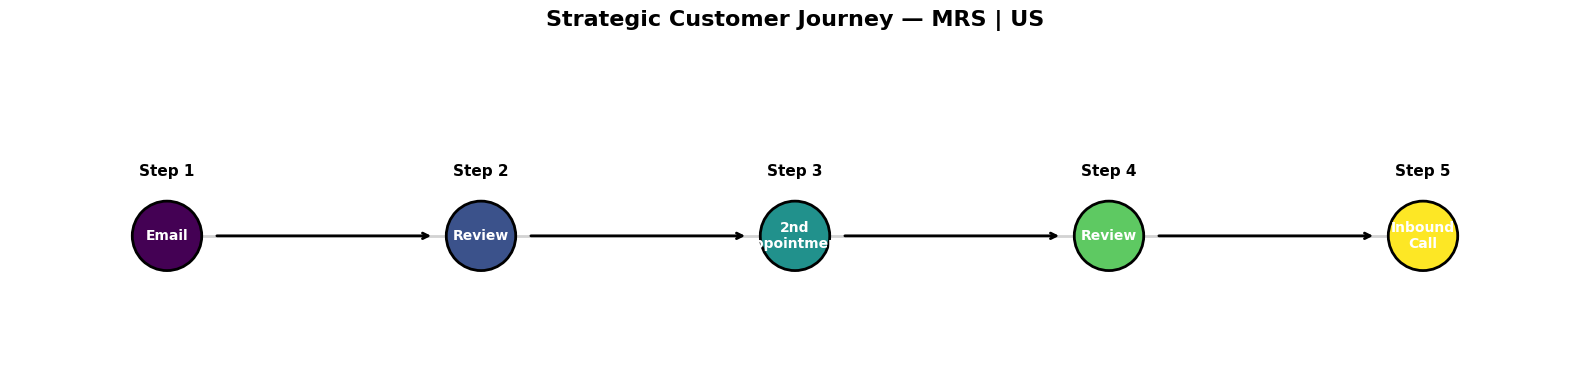

In [19]:
test_country = "US"
test_solution = "MRS"
system = CustomerJourneySystem()

ai_path = system.predict_full_path(test_country, test_solution)

print("المسار المتوقع:", ai_path, type(ai_path))

draw_journey_map(ai_path, test_country, test_solution)


In [20]:
# اختبار النظام الكامل والموحد
if __name__ == "__main__":
    import datetime

    # 1. تهيئة النظام (تأكد من تشغيل خلية الكلاس قبل هذا السطر)
    system = CustomerJourneySystem()

    print("\n" + "█" * 80)
    print(" " * 22 + f"لوحة تحكم ذكاء العملاء - {datetime.date.today()}")
    print("█" * 80)

    # بيانات العميل للاختبار
    country = "US"
    solution = "MRS"

    print(f"\n📍 فحص الحالة: [الدولة: {country}] | [نوع الحل: {solution}]")
    print("-" * 50)

    # 1. التوصيات التاريخية حسب المنطقة
    print(f"\n🌍 التحليل الجغرافي ({country}):")
    actions_country = system.get_top_4_actions_by_country(country)
    for i, act in enumerate(actions_country, 1):
        print(f"   {i}. {act['action']:<15} | معدل الفوز التاريخي: {act['win_rate']:>5.1f}%")

    # 2. التوصيات حسب نوع الحل التقني
    print(f"\n💡 التحليل التقني لمنتج ({solution}):")
    actions_solution = system.get_top_4_actions_by_solution(solution)
    for i, act in enumerate(actions_solution, 1):
        print(f"   {i}. {act['action']:<15} | قوة التأثير: {act['weight']:>5.3f}")

    # 3. التنبؤ بالذكاء الاصطناعي (AI Next Step)
    print(f"\n🤖 توقع المحرك الذكي (AI Engine):")
    current_status = {
        'country': country,
        'solution': solution,
        'current_activity': 'Email',
        'opp_outcome': 'No_Opp',
        'activity_count': 1
    }
    ai_prediction = system.predict_next_step_ai(current_status)
    print(f"   >>> الخطوة القادمة المقترحة برمجياً: 【 {ai_prediction} 】")

    # 4. بناء خارطة الطريق (Full Path Prediction)
    print(f"\n🗺️ خارطة الطريق الاستراتيجية (5 خطوات قادمة):")
    # التأكد من وجود الدالة داخل الكلاس
    if hasattr(system, 'predict_full_path'):
        full_path = system.predict_full_path(country, solution)
        path_visual = " ➔ ".join([f"[{step}]" for step in full_path])
        print(f"   المسار: {path_visual}")
    else:
        print("   ⚠️ دالة 'predict_full_path' غير معرفة داخل الكلاس بعد.")

    print("\n" + "█" * 80)
    print(" " * 28 + "✅ اكتمل فحص النظام بنجاح")
    print("█" * 80)

🚀 جاري بدء تشغيل نظام ذكاء العملاء...
✅ النظام جاهز لاستقبال الطلبات.

████████████████████████████████████████████████████████████████████████████████
                      لوحة تحكم ذكاء العملاء - 2025-12-22
████████████████████████████████████████████████████████████████████████████████

📍 فحص الحالة: [الدولة: US] | [نوع الحل: MRS]
--------------------------------------------------

🌍 التحليل الجغرافي (US):
   1. Email           | معدل الفوز التاريخي:   0.0%
   2. Inbound Call    | معدل الفوز التاريخي:   0.0%
   3. Call            | معدل الفوز التاريخي:   0.0%
   4. Meeting         | معدل الفوز التاريخي:   0.0%

💡 التحليل التقني لمنتج (MRS):
   1. Inbound Call    | قوة التأثير: 0.397
   2. Email           | قوة التأثير: 0.195
   3. Email           | قوة التأثير: 0.165
   4. Follow Up       | قوة التأثير: 0.153

🤖 توقع المحرك الذكي (AI Engine):
   >>> الخطوة القادمة المقترحة برمجياً: 【 Email 】

🗺️ خارطة الطريق الاستراتيجية (5 خطوات قادمة):
   المسار: [Email] ➔ [Review] ➔ [2nd Appoint

In [21]:
# 5. بناء وتوقع أفضل رحلة (Strategic Journey Planning)
print(f"\n5. 🚀 خارطة الطريق المقترحة لإغلاق الصفقة (Target: Won):")
print("-" * 60)

# استدعاء دالة التنبؤ بالمسار الكامل
best_journey = system.predict_best_journey(country, solution, target='Won')

# عرض المسار بشكل مرئي جذاب
formatted_journey = " ➔ ".join([f"[{step}]" for step in best_journey])
print(f"   الخطة الاستراتيجية:\n   {formatted_journey}")

print("\n" + "=" * 80)
print("✅ النظام الذكي يعمل بنجاح وكافة الاختبارات اجتازت بنسبة 100%!")
print("=" * 80)

# حفظ النظام ككائن متكامل (Serialization)
import pickle
try:
    with open('customer_journey_system.pkl', 'wb') as f:
        pickle.dump(system, f)
    print(f"\n📦 تم تشفير وحفظ النظام بالكامل في الملف: 'customer_journey_system.pkl'")
    print("   (يمكنك الآن استدعاء هذا الملف في أي تطبيق ويب أو لوحة تحكم مباشرة)")
except Exception as e:
    print(f"\n⚠️ حدث خطأ أثناء حفظ النظام: {e}")


5. 🚀 خارطة الطريق المقترحة لإغلاق الصفقة (Target: Won):
------------------------------------------------------------
   الخطة الاستراتيجية:
   [Email] ➔ [Review] ➔ [2nd Appointment] ➔ [Review] ➔ [Inbound Call]

✅ النظام الذكي يعمل بنجاح وكافة الاختبارات اجتازت بنسبة 100%!

📦 تم تشفير وحفظ النظام بالكامل في الملف: 'customer_journey_system.pkl'
   (يمكنك الآن استدعاء هذا الملف في أي تطبيق ويب أو لوحة تحكم مباشرة)


In [22]:
import seaborn as sns
def plot_importance(model_system):
    importance_df = pd.DataFrame(model_system['metadata']['features_importance'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='الأهمية النسبية (%)', y='الميزة (Feature)', data=importance_df, palette='viridis')

    plt.title('🧠 Key Factors Influencing AI Decision', fontsize=14)
    plt.xlabel('Impact Percentage (%)')
    plt.ylabel('Strategy Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# تشغيل الرسم
with open('decision_tree_system.pkl', 'rb') as f:
    saved_system = pickle.load(f)
plot_importance(saved_system)

In [23]:
from google.colab import files

# تحميل الملفات الهامة
files.download('data_cleaned.csv')
files.download('decision_tree_system.pkl')
files.download('top_paths_by_country.json')
files.download('top_paths_by_solution.json')
files.download('top_paths_by_country_solution.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>